# **Pokemon Clustering Data Project**
# **Author:** Mariah Noelle Cornelio
# **Data Goal:** Which Pokémon are the most similar based on their stats?

In this project, we will analyze and use K-Means clustering and different machine learning algorithms to see which Pokémon are the most similar based on their attributes. The data obtained was from:

https://www.reddit.com/r/pokemon/comments/z0mjwt/national_dex_spreadsheet_updated_for_gen_9/ by Arce_Havrek! Thank you so much!


## Importing and data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
pokemon_df=pd.read_csv("pokemon_dataset.csv")
pokemon_df.head()

,Pokemon,HP,Atk,Def,SpA,SpD,Spe,Total,Type I,Type II,Generation
0,Bulbasaur,45.0,49.0,49.0,65.0,65.0,45.0,318.0,Grass,Poison,1.0
1,Ivysaur,60.0,62.0,63.0,80.0,80.0,60.0,405.0,Grass,Poison,1.0
2,Venusaur,80.0,82.0,83.0,100.0,100.0,80.0,525.0,Grass,Poison,1.0
3,Charmander,39.0,52.0,43.0,60.0,50.0,65.0,309.0,Fire,NaN,1.0
4,Charmeleon,58.0,64.0,58.0,80.0,65.0,80.0,405.0,Fire,NaN,1.0


In [3]:
pokemon_df.shape

(1187, 11)

In [4]:
# Remove the mega pokemon because we only want to compare base stat pokemon
pokemon_df=pokemon_df[~pokemon_df["Pokemon"].str.contains("Mega", case=False, na=False)]
has_mega_pokemon=pokemon_df["Pokemon"].str.contains("Mega", case=False, na=False).any()
if has_mega_pokemon:
    print("There are still Mega Pokémon in the dataframe.")
else:
    print("There are no Mega Pokémon left in the dataframe.")


There are no Mega Pokémon left in the dataframe.


In [5]:
pokemon_df=pokemon_df.drop("Total", axis=1) # We don't need the Total column of the stats
pokemon_df.isnull().sum()
# We can remove the null values later after changing the categorical indices to numerical values

Pokemon         2
HP              2
Atk             2
Def             2
SpA             2
SpD             2
Spe             2
Type I          2
Type II       583
Generation      2
dtype: int64

### We want to change the categorical values of the Type I and Type II column into numerical values 

In [6]:
pokemon_df["Type I"].value_counts()

Water       146
Normal      124
Grass       107
Bug          84
Psychic      76
Fire         70
Electric     67
Rock         62
Poison       54
Dark         49
Fighting     46
Ghost        44
Ice          44
Ground       44
Dragon       42
Steel        33
Fairy        31
Flying       12
Name: Type I, dtype: int64

In [7]:
pokemon_df["Type II"].value_counts()

Flying      98
Fairy       41
Psychic     40
Steel       37
Ground      35
Ghost       34
Poison      33
Fighting    33
Dragon      31
Dark        29
Grass       24
Water       21
Fire        21
Rock        20
Ice         18
Normal      16
Electric    15
Bug          8
Name: Type II, dtype: int64

In [8]:
types={"Normal": 1, "Fire": 2, "Water": 3, "Electric": 4, "Grass": 5, "Ice": 6, "Fighting": 7,
    "Poison": 8, "Ground": 9, "Flying": 10, "Psychic": 11, "Bug": 12, "Rock": 13, "Ghost": 14,
    "Dragon": 15, "Dark": 16, "Steel": 17, "Fairy": 18}

pokemon_df["Type I"]=pokemon_df["Type I"].replace(types)
pokemon_df["Type II"]=pokemon_df["Type II"].replace(types)
pokemon_df["Type I"].fillna("Unknown", inplace=True)
pokemon_df["Type II"].fillna("Unknown", inplace=True)
print(pokemon_df)

           Pokemon    HP    Atk    Def    SpA    SpD   Spe   Type I  Type II  \
0        Bulbasaur  45.0   49.0   49.0   65.0   65.0  45.0      5.0      8.0   
1          Ivysaur  60.0   62.0   63.0   80.0   80.0  60.0      5.0      8.0   
2         Venusaur  80.0   82.0   83.0  100.0  100.0  80.0      5.0      8.0   
3       Charmander  39.0   52.0   43.0   60.0   50.0  65.0      2.0  Unknown   
4       Charmeleon  58.0   64.0   58.0   80.0   65.0  80.0      2.0  Unknown   
...            ...   ...    ...    ...    ...    ...   ...      ...      ...   
1181     H. Goodra  80.0  100.0  100.0  110.0  150.0  60.0     15.0     17.0   
1182    H. Avalugg  95.0  127.0  184.0   34.0   36.0  38.0      6.0     13.0   
1184  H. Decidueye  88.0  112.0   80.0   95.0   95.0  60.0      5.0      7.0   
1185           NaN   NaN    NaN    NaN    NaN    NaN   NaN  Unknown  Unknown   
1186           NaN   NaN    NaN    NaN    NaN    NaN   NaN  Unknown  Unknown   

      Generation  
0            1.0  
1

In [9]:
# Drop the last 2 empty rows
pokemon_df=pokemon_df.drop(index=[1185, 1186])
pokemon_df.reset_index(drop=True, inplace=True)
print(pokemon_df)

                   Pokemon    HP    Atk    Def    SpA    SpD   Spe Type I  \
0                Bulbasaur  45.0   49.0   49.0   65.0   65.0  45.0    5.0   
1                  Ivysaur  60.0   62.0   63.0   80.0   80.0  60.0    5.0   
2                 Venusaur  80.0   82.0   83.0  100.0  100.0  80.0    5.0   
3               Charmander  39.0   52.0   43.0   60.0   50.0  65.0    2.0   
4               Charmeleon  58.0   64.0   58.0   80.0   65.0  80.0    2.0   
...                    ...   ...    ...    ...    ...    ...   ...    ...   
1130  Gimmighoul - Roaming  45.0   30.0   25.0   75.0   45.0  80.0   14.0   
1131            H. Sliggoo  58.0   75.0   83.0   83.0  113.0  40.0   15.0   
1132             H. Goodra  80.0  100.0  100.0  110.0  150.0  60.0   15.0   
1133            H. Avalugg  95.0  127.0  184.0   34.0   36.0  38.0    6.0   
1134          H. Decidueye  88.0  112.0   80.0   95.0   95.0  60.0    5.0   

      Type II  Generation  
0         8.0         1.0  
1         8.0      

In [10]:
pokemon_df.isnull().sum()

# This looks better!

Pokemon       0
HP            0
Atk           0
Def           0
SpA           0
SpD           0
Spe           0
Type I        0
Type II       0
Generation    0
dtype: int64

## Data viz

In [11]:
pokemon_df.describe()

,HP,Atk,Def,SpA,SpD,Spe,Generation
count,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000
mean,70.529515,79.157709,73.304846,71.184141,71.029075,68.696916,4.628194
std,27.210019,30.626250,29.748542,31.105024,27.535420,29.611651,2.610030
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000
25%,50.000000,55.000000,50.000000,47.500000,50.000000,45.000000,2.000000
50%,68.000000,75.000000,70.000000,65.000000,70.000000,65.000000,5.000000
75%,85.000000,100.000000,90.000000,92.000000,86.000000,90.000000,7.000000
max,255.000000,181.000000,250.000000,180.000000,250.000000,200.000000,9.000000


/var/folders/q4/414ry47d1hv7zj62ggf6vkz40000gn/T/ipykernel_51814/3302905207.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation=pokemon_df.corr()


<Axes: >

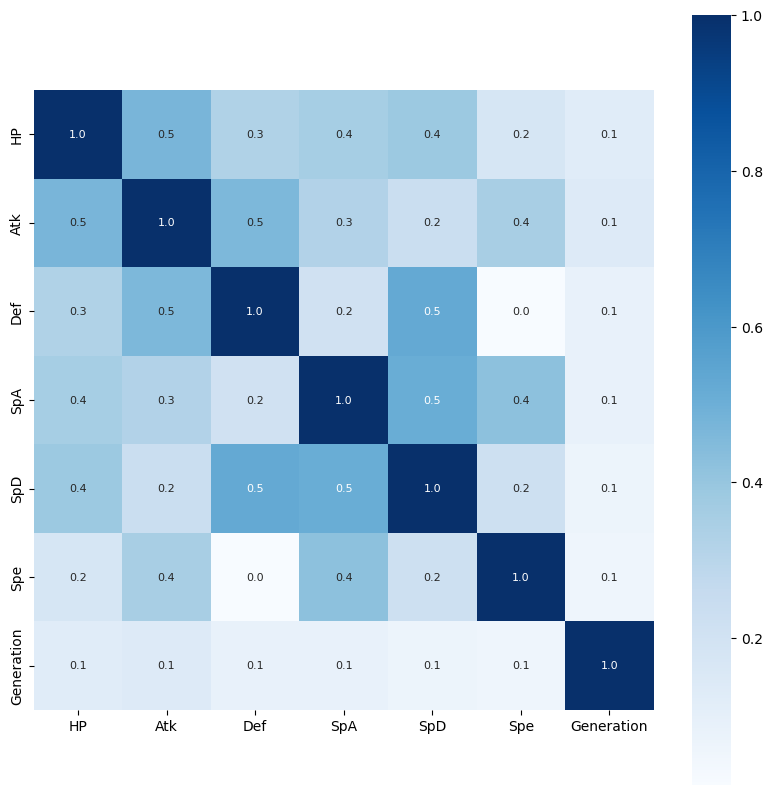

In [12]:
correlation=pokemon_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt=".1f", annot=True, annot_kws={"size":8}, cmap="Blues")

## Finding the best cluster number

- Do a mock model training to figure out the best cluster number
stat_cols=["HP", "Atk", "Def", "SpA", "SpD", "Spe", "Generation"]
scaler=StandardScaler()
scaled_stats=scaler.fit_transform(pokemon_df[stat_cols])

- For the scores later
inertia=[]
silhouette_scores=[]
davies_bouldin_scores=[]
calinski_harabasz_scores=[]

- cluster_range=range(2, 21) # 2 was best number, 1-500 pokemon in each group
- cluster_range=range(50, 151)  # 55 was best number, 10-20 in each group
cluster_range=range(119, 238) # 5-10 in each group, 80 or 120 was a good number

for n_clusters in cluster_range:
    kmeans_model=KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels=kmeans_model.fit_predict(scaled_stats)
    
    # Find the elbow method inertia
    inertia.append(kmeans_model.inertia_)
    # Silhouette Score
    if n_clusters>1:
        sil_score=silhouette_score(scaled_stats, cluster_labels)
        silhouette_scores.append(sil_score)
    # Davies-Bouldin Score
    db_score=davies_bouldin_score(scaled_stats, cluster_labels)
    davies_bouldin_scores.append(db_score)
    # Calinski-Harabasz Score
    ch_score=calinski_harabasz_score(scaled_stats, cluster_labels)
    calinski_harabasz_scores.append(ch_score)

- Plotting
valid_cluster_range=range(2, len(silhouette_scores) + 2)
plt.figure(figsize=(12, 8))
- Elbow Method Plot
plt.subplot(2, 2, 1)
plt.plot(cluster_range, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
- Silhouette Score Plot
plt.subplot(2, 2, 2)
plt.plot(valid_cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
- Davies-Bouldin Score Plot
plt.subplot(2, 2, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o')
plt.title("Davies-Bouldin Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Score")
- Calinski-Harabasz Score Plot
plt.subplot(2, 2, 4)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o')
plt.title("Calinski-Harabasz Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Score")
plt.tight_layout()
plt.show()

In [13]:
scaler=StandardScaler()
stat_cols=["HP", "Atk", "Def", "SpA", "SpD", "Spe", "Generation"]
scaled_stats=scaler.fit_transform(pokemon_df[stat_cols])
print(scaled_stats)

[[-0.93865311 -0.98513542 -0.81736979 ... -0.21905359 -0.80060928
  -1.39070949]
 [-0.38714258 -0.56047583 -0.34655104 ...  0.32593946 -0.29382861
  -1.39070949]
 [ 0.3482048   0.09284662  0.32604717 ...  1.05259686  0.38187896
  -1.39070949]
 ...
 [ 0.3482048   0.68083682  0.89775565 ...  2.86924036 -0.29382861
   1.29243449]
 [ 0.89971534  1.56282212  3.72266814 ... -1.27270683 -1.03710693
   1.29243449]
 [ 0.64234375  1.07283029  0.22515744 ...  0.87093251 -0.29382861
   1.29243449]]


In [14]:
kmeans_model=KMeans(n_clusters=90, random_state=42) # Play around with cluster numbers
pokemon_df["Cluster"]=kmeans_model.fit_predict(scaled_stats)

In [15]:
pokemon_df.head()

,Pokemon,HP,Atk,Def,SpA,SpD,Spe,Type I,Type II,Generation,Cluster
0,Bulbasaur,45.0,49.0,49.0,65.0,65.0,45.0,5.0,8.0,1.0,77
1,Ivysaur,60.0,62.0,63.0,80.0,80.0,60.0,5.0,8.0,1.0,19
2,Venusaur,80.0,82.0,83.0,100.0,100.0,80.0,5.0,8.0,1.0,85
3,Charmander,39.0,52.0,43.0,60.0,50.0,65.0,2.0,Unknown,1.0,77
4,Charmeleon,58.0,64.0,58.0,80.0,65.0,80.0,2.0,Unknown,1.0,32


## Result analysis

In [16]:
pokemon_df[["Pokemon", "Cluster"]].head()

,Pokemon,Cluster
0,Bulbasaur,77
1,Ivysaur,19
2,Venusaur,85
3,Charmander,77
4,Charmeleon,32


In [17]:
pokemon_df["Cluster"].value_counts()

43    35
27    34
77    31
5     29
46    28
      ..
11     2
73     1
78     1
86     1
14     1
Name: Cluster, Length: 90, dtype: int64

In [18]:
cluster_stats=pokemon_df.groupby("Cluster")[stat_cols].mean()
print("\nAverage Stats for Each Cluster:")
print(cluster_stats)


Average Stats for Each Cluster:
                HP         Atk         Def         SpA         SpD  \
Cluster                                                              
0        99.333333  135.555556   95.111111  160.444444  116.000000   
1        57.884615   87.076923   56.230769   41.153846   47.423077   
2        88.000000  108.388889   81.000000   72.055556   94.333333   
3        92.000000   59.000000   85.750000   52.500000   80.750000   
4        70.647059   95.352941   59.294118   95.705882   57.058824   
...            ...         ...         ...         ...         ...   
85       89.684211   95.315789   86.842105  104.315789   90.526316   
86       50.000000  180.000000   20.000000  180.000000   20.000000   
87       98.125000  133.625000   86.500000   71.375000   96.500000   
88       70.000000   82.428571   62.428571   72.571429   63.571429   
89       96.666667  123.000000  167.666667   32.666667   34.000000   

                Spe  Generation  
Cluster               

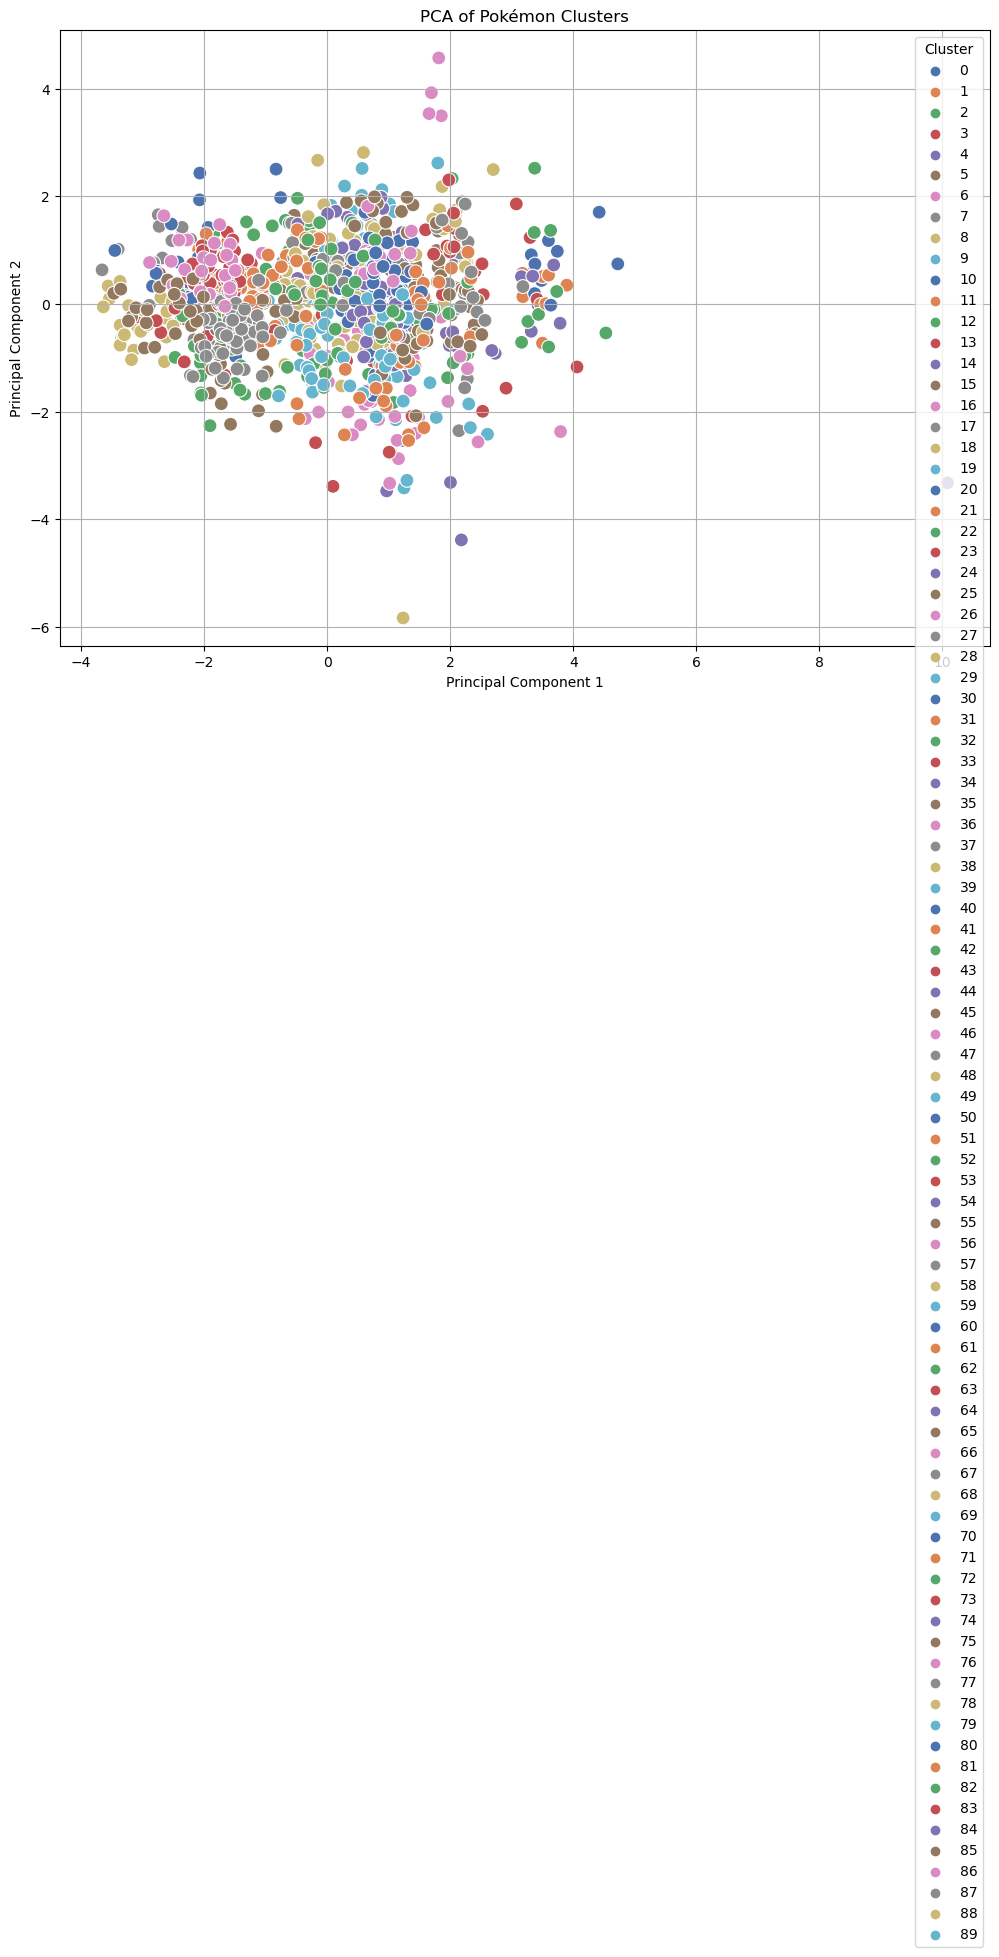

In [19]:
# Visualizing using PCA

pca=PCA(n_components=2)
pca_results=pca.fit_transform(scaled_stats)

pokemon_pca_df=pd.DataFrame(data=pca_results, columns=["PC1", "PC2"])
pokemon_pca_df["Cluster"]=pokemon_df["Cluster"]
pokemon_pca_df["Pokemon"]=pokemon_df["Pokemon"]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pokemon_pca_df, x="PC1", y="PC2", hue="Cluster", palette="deep", s=100)
plt.title("PCA of Pokémon Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

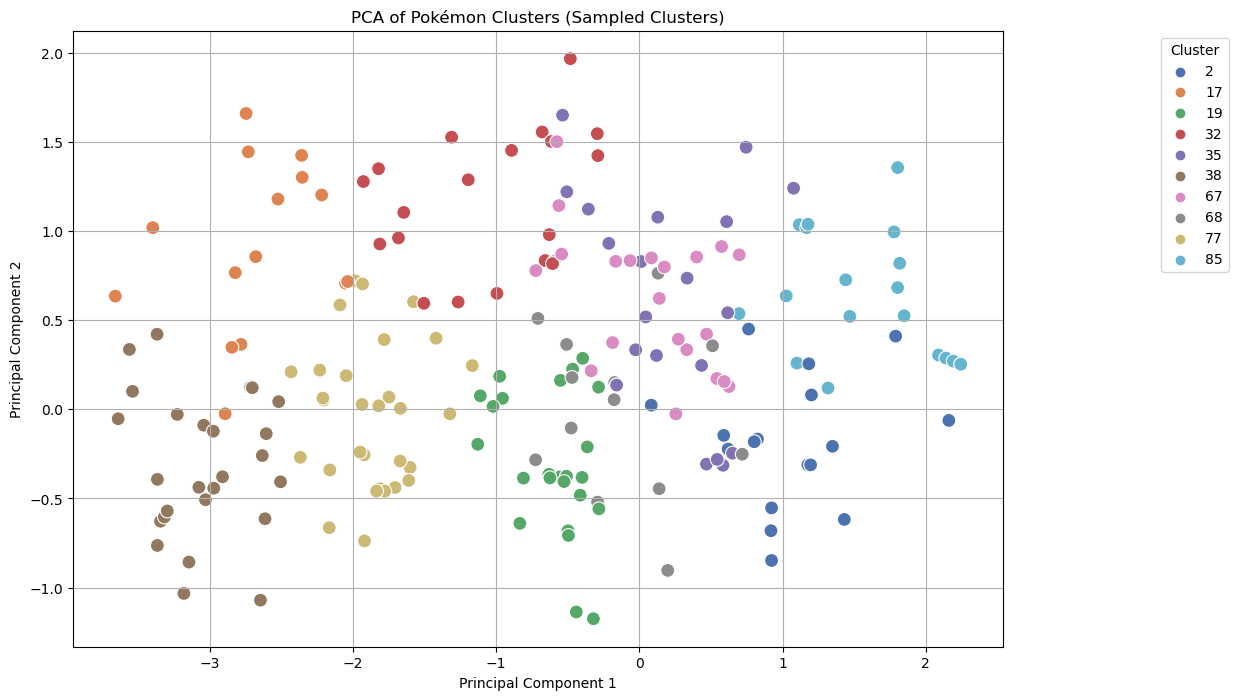

In [20]:
unique_clusters=pokemon_pca_df["Cluster"].unique()
sampled_clusters=unique_clusters[:10]  # Displays first 10 clusters bcs legend is too big

sampled_pokemon_pca_df=pokemon_pca_df[pokemon_pca_df["Cluster"].isin(sampled_clusters)]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=sampled_pokemon_pca_df, x="PC1", y="PC2", hue="Cluster", palette="deep", s=100)
plt.title("PCA of Pokémon Clusters (Sampled Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()

In [21]:
sorted_pokemon_df=pokemon_df.sort_values(by="Cluster")
print(sorted_pokemon_df[["Pokemon", "Cluster"]+stat_cols].head(20))

# file_name="sorted_pokemon_clusters_100.csv"
# sorted_pokemon_df.to_csv(file_name, index=False)

           Pokemon  Cluster     HP    Atk    Def    SpA    SpD    Spe  \
717   White Kyurem        0  125.0  120.0   90.0  170.0  100.0   95.0   
913    DW Necrozma        0   97.0  113.0  109.0  157.0  127.0   77.0   
534         Palkia        0   90.0  120.0  100.0  150.0  120.0  100.0   
425       Rayquaza        0  105.0  150.0   90.0  150.0   90.0   95.0   
815      Hoopa (U)        0   80.0  160.0   60.0  170.0  130.0   80.0   
914     U Necrozma        0   97.0  167.0   97.0  167.0   97.0  129.0   
704       Reshiram        0  100.0  120.0  100.0  150.0  120.0   90.0   
431  Primal Kyogre        0  100.0  150.0   90.0  180.0  160.0   90.0   
533         Dialga        0  100.0  120.0  120.0  150.0  100.0   90.0   
649     Karrablast        1   50.0   75.0   45.0   40.0   45.0   60.0   
722    G. Darumaka        1   70.0   90.0   45.0   15.0   45.0   50.0   
672        Fraxure        1   66.0  117.0   70.0   40.0   50.0   67.0   
833     Crabrawler        1   47.0   82.0   57.0   

## Best Pokemon Cluster for each Stat

In [22]:
# Calculate the number of Pokémon in each cluster
cluster_counts=pokemon_df["Cluster"].value_counts()
print("Cluster Counts:\n", cluster_counts)

Cluster Counts:
 43    35
27    34
77    31
5     29
46    28
      ..
11     2
73     1
78     1
86     1
14     1
Name: Cluster, Length: 90, dtype: int64


In [23]:
# Filter clusters to only those with between 5-10 Pokémon
valid_clusters=cluster_counts[(cluster_counts>=5)&(cluster_counts<=10)].index
print("Valid Clusters (at least 5 Pokémon):", valid_clusters) 

Valid Clusters (at least 5 Pokémon): Int64Index([74, 39, 0, 37, 31, 72, 8, 71, 10, 87, 25, 61, 23, 76, 69, 24, 64,
            80, 13, 6],
           dtype='int64')


In [24]:
# Calculate average stats per valid cluster
average_stats_per_cluster=pokemon_df[pokemon_df["Cluster"].isin(valid_clusters)].groupby("Cluster")[["HP", "Atk", "Def", "SpA", "SpD", "Spe"]].mean()
print("Average Stats Per Valid Cluster:\n", average_stats_per_cluster) 

Average Stats Per Valid Cluster:
                  HP         Atk         Def         SpA         SpD  \
Cluster                                                               
0         99.333333  135.555556   95.111111  160.444444  116.000000   
6        102.200000  141.200000  121.800000   71.800000  101.600000   
8         67.111111   94.333333  122.777778   58.777778   71.111111   
10        38.125000   51.750000   85.625000   68.000000   46.875000   
13        59.000000   73.600000  130.400000   41.600000  119.400000   
23        91.000000   94.571429   94.285714  142.571429  108.571429   
24        67.200000  104.200000  194.200000   60.600000   74.200000   
25        99.125000   83.000000   98.250000   93.500000   83.625000   
31       135.666667  126.888889  101.777778  119.666667   98.555556   
37        87.666667  123.222222   84.444444   91.777778   77.444444   
39        77.111111   84.333333   94.666667   60.000000   94.777778   
61        85.750000   75.375000   93.125000

In [25]:
# Identify the clusters with the highest average for each stat
highest_stats_clusters={}
for stat in ["HP", "Atk", "Def", "SpA", "SpD", "Spe"]:
    if stat in average_stats_per_cluster.columns and not average_stats_per_cluster[stat].empty:
        highest_cluster=average_stats_per_cluster[stat].idxmax()
        highest_value=average_stats_per_cluster[stat].max()
        highest_stats_clusters[stat]=(highest_cluster, highest_value)

# Results
if highest_stats_clusters:  
    highest_stats_df=pd.DataFrame(highest_stats_clusters, index=["Cluster", "Average Value"]).T
    print(highest_stats_df)

    for stat, (cluster, boop) in highest_stats_clusters.items():
        print(f"\nPokémon in the highest {stat} cluster (Cluster {cluster}):")
        
        pokemon_in_cluster=pokemon_df[pokemon_df["Cluster"]==cluster]
        if not pokemon_in_cluster.empty:
            print(pokemon_in_cluster["Pokemon"].tolist())
        else:
            print(f"No Pokémon found in Cluster {cluster} for {stat}.")
else:
    print("No valid clusters with at least 5 Pokémon found.")

     Cluster  Average Value
HP      69.0     140.666667
Atk     72.0     153.444444
Def     24.0     194.200000
SpA      0.0     160.444444
SpD     76.0     136.428571
Spe     64.0     137.400000

Pokémon in the highest HP cluster (Cluster 69):
['Melmetal', 'Greedent', 'Ursaluna', 'Dondozo', 'Iron Hands', 'Ting-Lu']

Pokémon in the highest Atk cluster (Cluster 72):
['Tyranitar', 'Metagross', 'Groudon', 'Primal Groudon', 'Regigigas', 'Zekrom', 'Therian Landorus', 'Black Kyurem', 'DM Necrozma']

Pokémon in the highest Def cluster (Cluster 24):
['Cloyster', 'Steelix', 'Aggron', 'Regirock', 'Stakataka']

Pokémon in the highest SpA cluster (Cluster 0):
['Rayquaza', 'Primal Kyogre', 'Dialga', 'Palkia', 'Reshiram', 'White Kyurem', 'Hoopa (U)', 'DW Necrozma', 'U Necrozma']

Pokémon in the highest SpD cluster (Cluster 76):
['Dusclops', 'Bastiodon', 'Probopass', 'Cofagrigus', 'S Aegislash', 'Carbink', 'Toxapex']

Pokémon in the highest Spe cluster (Cluster 64):
['Zacian (H)', 'Zamazenta (H)', 'Z

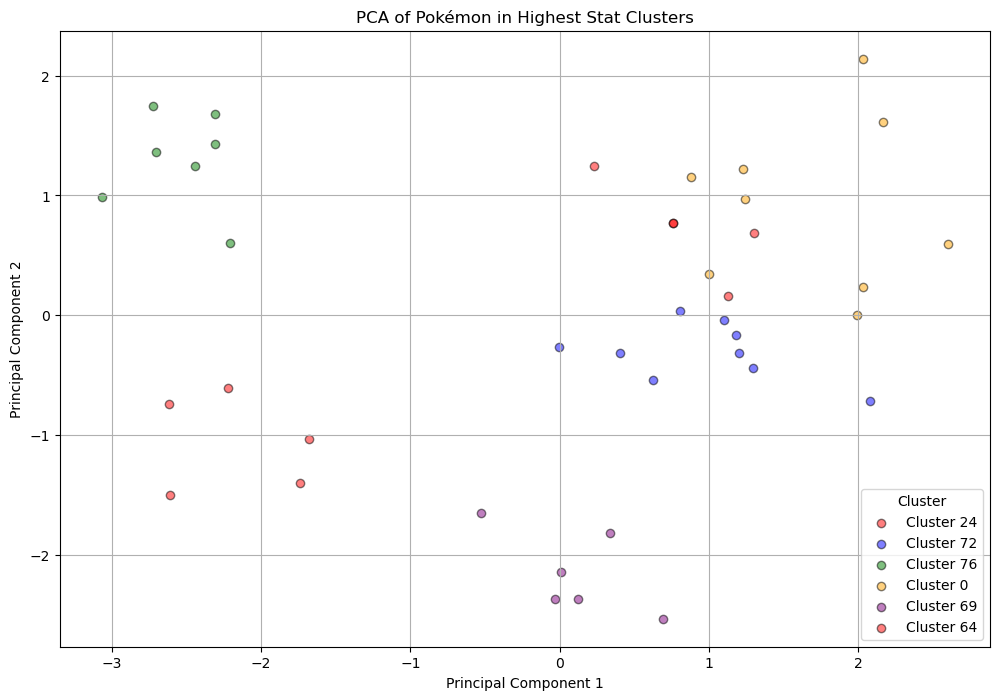

In [37]:
# Clusters with the highest stats - manually edit this if it changes
highest_stats_clusters={"HP": 69.0, "Atk": 72.0, "Def": 24.0, "SpA": 0.0, "SpD": 76.0, "Spe": 64.0}
valid_clusters=highest_stats_clusters.values()

filtered_pokemon_df=pokemon_df[pokemon_df["Cluster"].isin(valid_clusters)]

# Step 3
if filtered_pokemon_df.empty:
    print("No Pokémon found in the selected clusters.")
else:
    stat_cols=["HP", "Atk", "Def", "SpA", "SpD", "Spe"]
    if not all(col in filtered_pokemon_df.columns for col in stat_cols):
        print("Some stat columns are missing in the filtered DataFrame.")
    else:
        scaler=StandardScaler()
        scaled_stats=scaler.fit_transform(filtered_pokemon_df[stat_cols])

        pca=PCA(n_components=2)
        pca_results=pca.fit_transform(scaled_stats)
        pokemon_pca_df=pd.DataFrame(data=pca_results, columns=["PC1", "PC2"])
        pokemon_pca_df["Cluster"]=filtered_pokemon_df["Cluster"].values
        pokemon_pca_df["Pokemon"]=filtered_pokemon_df["Pokemon"].values
        unique_clusters=pokemon_pca_df['Cluster'].unique()
        colors=["red", "blue", "green", "orange", "purple"] 

        plt.figure(figsize=(12, 8))
        for idx, cluster in enumerate(unique_clusters):
            cluster_data=pokemon_pca_df[pokemon_pca_df["Cluster"]==cluster]
            plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                        c=colors[idx % len(colors)], 
                        label=f"Cluster {cluster}", 
                        alpha=0.5, 
                        edgecolor="k")
        plt.title("PCA of Pokémon in Highest Stat Clusters")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend(title="Cluster")
        plt.grid(True)
        plt.savefig("pca_pokemon_highest_stat_clusters.png", dpi=300)
        plt.show()

In [28]:
pokemon_pca_df.head(20)

,PC1,PC2,Cluster,Pokemon
0,-1.675239,-1.038012,24,Cloyster
1,-2.609286,-1.500257,24,Steelix
2,0.402254,-0.312697,72,Tyranitar
3,-1.739244,-1.399692,24,Aggron
4,-2.445113,1.247116,76,Dusclops
5,-0.002666,-0.263786,72,Metagross
6,-2.224054,-0.610905,24,Regirock
7,0.624876,-0.544345,72,Groudon
8,1.992034,0.002135,0,Rayquaza
9,2.030801,2.141934,0,Primal Kyogre


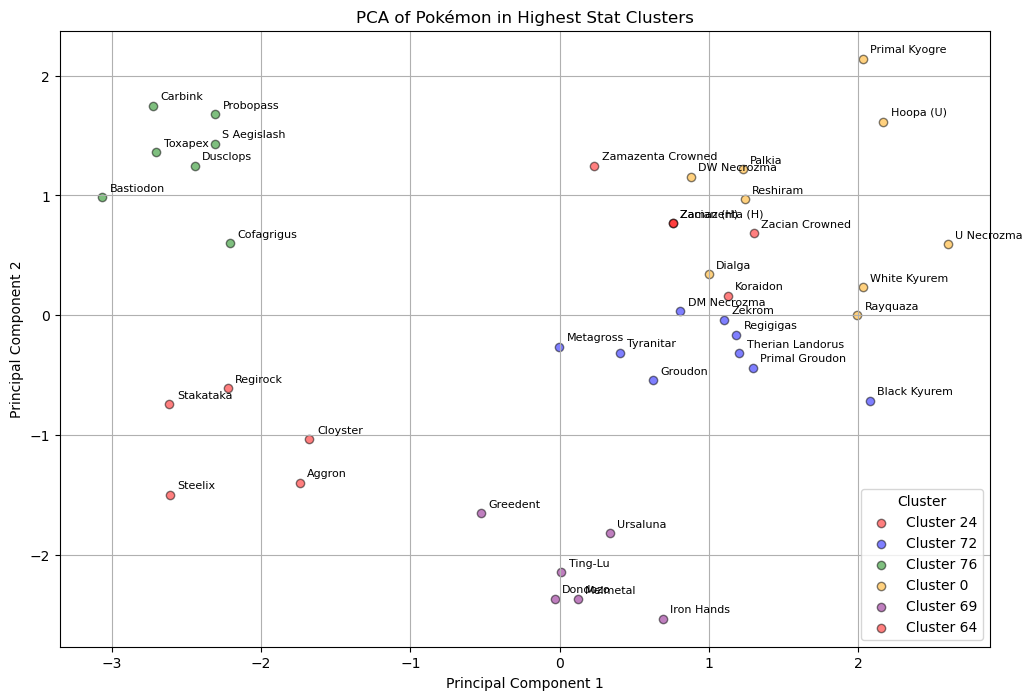

In [50]:
# Step 4
if filtered_pokemon_df.empty:
    print("No Pokémon found in the selected clusters.")
else:
    stat_cols=["HP", "Atk", "Def", "SpA", "SpD", "Spe"]
    if not all(col in filtered_pokemon_df.columns for col in stat_cols):
        print("Some stat columns are missing in the filtered DataFrame.")
    else:
        scaler=StandardScaler()
        scaled_stats=scaler.fit_transform(filtered_pokemon_df[stat_cols])

        pca=PCA(n_components=2)
        pca_results=pca.fit_transform(scaled_stats)
        pokemon_pca_df=pd.DataFrame(data=pca_results, columns=["PC1", "PC2"])
        pokemon_pca_df["Cluster"]=filtered_pokemon_df["Cluster"].values
        pokemon_pca_df["Pokemon"]=filtered_pokemon_df["Pokemon"].values

        unique_clusters=pokemon_pca_df['Cluster'].unique()
        colors=["red", "blue", "green", "orange", "purple"] 

        plt.figure(figsize=(12, 8))
        for idx, cluster in enumerate(unique_clusters):
            cluster_data=pokemon_pca_df[pokemon_pca_df["Cluster"]==cluster]
            plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                        c=colors[idx % len(colors)], 
                        label=f"Cluster {cluster}", 
                        alpha=0.5, 
                        edgecolor="k")

        # for i in range(pokemon_pca_df.shape[0]):
            # plt.annotate(pokemon_pca_df["Pokemon"].iloc[i], (pokemon_pca_df["PC1"].iloc[i], pokemon_pca_df["PC2"].iloc[i]), fontsize=8)
        # for i in range(pokemon_pca_df.shape[0]):
            # plt.annotate(
            # pokemon_pca_df["Pokemon"].iloc[i], 
            # (pokemon_pca_df["PC1"].iloc[i], pokemon_pca_df["PC2"].iloc[i]+0.06), 
            # ha='center') 

        for i in range(pokemon_pca_df.shape[0]):
            plt.annotate(
            pokemon_pca_df["Pokemon"].iloc[i], 
            (pokemon_pca_df["PC1"].iloc[i]+0.05, pokemon_pca_df["PC2"].iloc[i]+0.05),
            fontsize=8)

        plt.title("PCA of Pokémon in Highest Stat Clusters")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend(title="Cluster")
        plt.grid(True)
        plt.savefig("pca_pokemon_LABLED_highest_stat_clusters.png", dpi=300)
        plt.show()

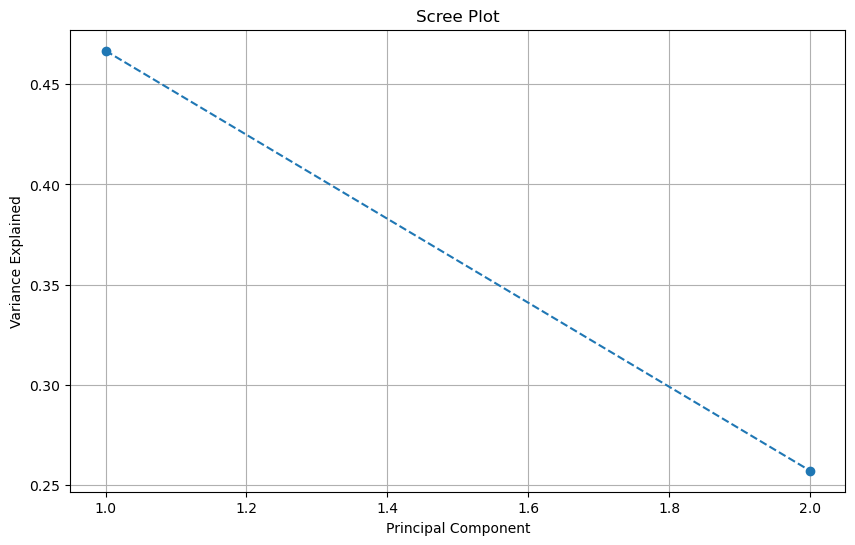

Component Loadings:
            HP       Atk       Def       SpA       SpD       Spe
PC1  0.376645  0.502091 -0.470142  0.443613 -0.060202  0.429642
PC2 -0.487806 -0.195888 -0.153826  0.301218  0.728865  0.279345


In [30]:
# Step 1: Analyze the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.show()

# Step 2: Display component loadings
loadings=pd.DataFrame(pca.components_, columns=stat_cols, index=[f"PC{i+1}" for i in range(len(pca.components_))])
print("Component Loadings:\n", loadings)

#### Step 1: Analyze the Explained Variance
- What it is: This shows how much of the data's information (variance) is captured by each principal component (PC).
- How to use it: Look for the scree plot to see which PCs capture most of the variance. You want to find a point where the curve flattens (the "elbow"), indicating that additional PCs don’t add much new information.
#### Step 2: Examine the Principal Components
- What it is: This involves looking at the component loadings, which tell you how much each original feature (like HP, Attack, etc.) contributes to the PCs.
- How to use it: High absolute values (close to 1 or -1) indicate strong relationships. For example, if Attack has a high loading on PC1, it means PC1 represents Attack effectively.
#### Step 3: Visualize PCA Results
- What it is: Create scatter plots of the first two PCs to visualize how data points are distributed and grouped.
- How to use it: Use colors to represent different clusters. This helps you see if similar Pokémon are close together in the plot and identify patterns or clusters.
#### Step 4: Identify Clusters and Patterns
- What it is: Analyze the scatter plots for groups of points (clusters) and any points that stand out (outliers).
- How to use it: Look for tightly grouped points, which suggest similar Pokémon, and note any outliers that may represent unique cases needing further investigation.

In [31]:
highest_stats_df=pd.DataFrame(highest_stats_clusters, index=["Cluster", "Average Value"]).T
pokemon_in_clusters={}

for stat in highest_stats_df.index:
    cluster_number=highest_stats_df.loc[stat, "Cluster"]
    pokemon_list=pokemon_df[pokemon_df["Cluster"]==cluster_number]["Pokemon"].tolist()
    pokemon_in_clusters[stat]={"Cluster": cluster_number, "Pokémon": pokemon_list}

pokemon_in_clusters_df=pd.DataFrame.from_dict(pokemon_in_clusters, orient="index")
print(pokemon_in_clusters_df)

     Cluster                                            Pokémon
HP      69.0  [Melmetal, Greedent, Ursaluna, Dondozo, Iron H...
Atk     72.0  [Tyranitar, Metagross, Groudon, Primal Groudon...
Def     24.0   [Cloyster, Steelix, Aggron, Regirock, Stakataka]
SpA      0.0  [Rayquaza, Primal Kyogre, Dialga, Palkia, Resh...
SpD     76.0  [Dusclops, Bastiodon, Probopass, Cofagrigus, S...
Spe     64.0  [Zacian (H), Zamazenta (H), Zacian Crowned, Za...


## What I learned
- Playing around with the cluster numbers. The more clusters mean more similar groups
- Finding the clusters with the highest stat because some clusters contained 1 Pokemon while other contained 27. I needed to find a balance so I did clusters with Pokemon between 5-10.
- How PCA works
- Finding out how many n clusters to use by using other statistical methods
- Removing the mega-evolved pokemon from the dataset because I realized that gives them an advantage and I'm supposed to compare base stats
    - I first went all the way to 300 because I thought the values would reach equilibrium but it did not
    - So I had to choose which clusters were more defined with n=80,90,100, or 120

## 3 PCA pipeline for fun

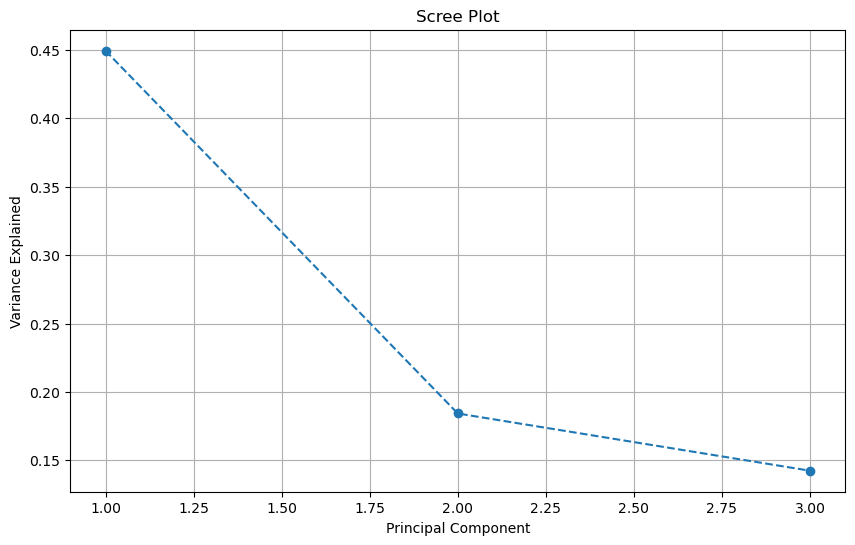

Component Loadings:
            HP       Atk       Def       SpA       SpD       Spe
PC1  0.422441  0.432745  0.394176  0.430768  0.448834  0.303131
PC2 -0.128804 -0.020014 -0.571302  0.353567 -0.175096  0.707781
PC3  0.277189  0.646632 -0.005627 -0.390654 -0.582325  0.115275


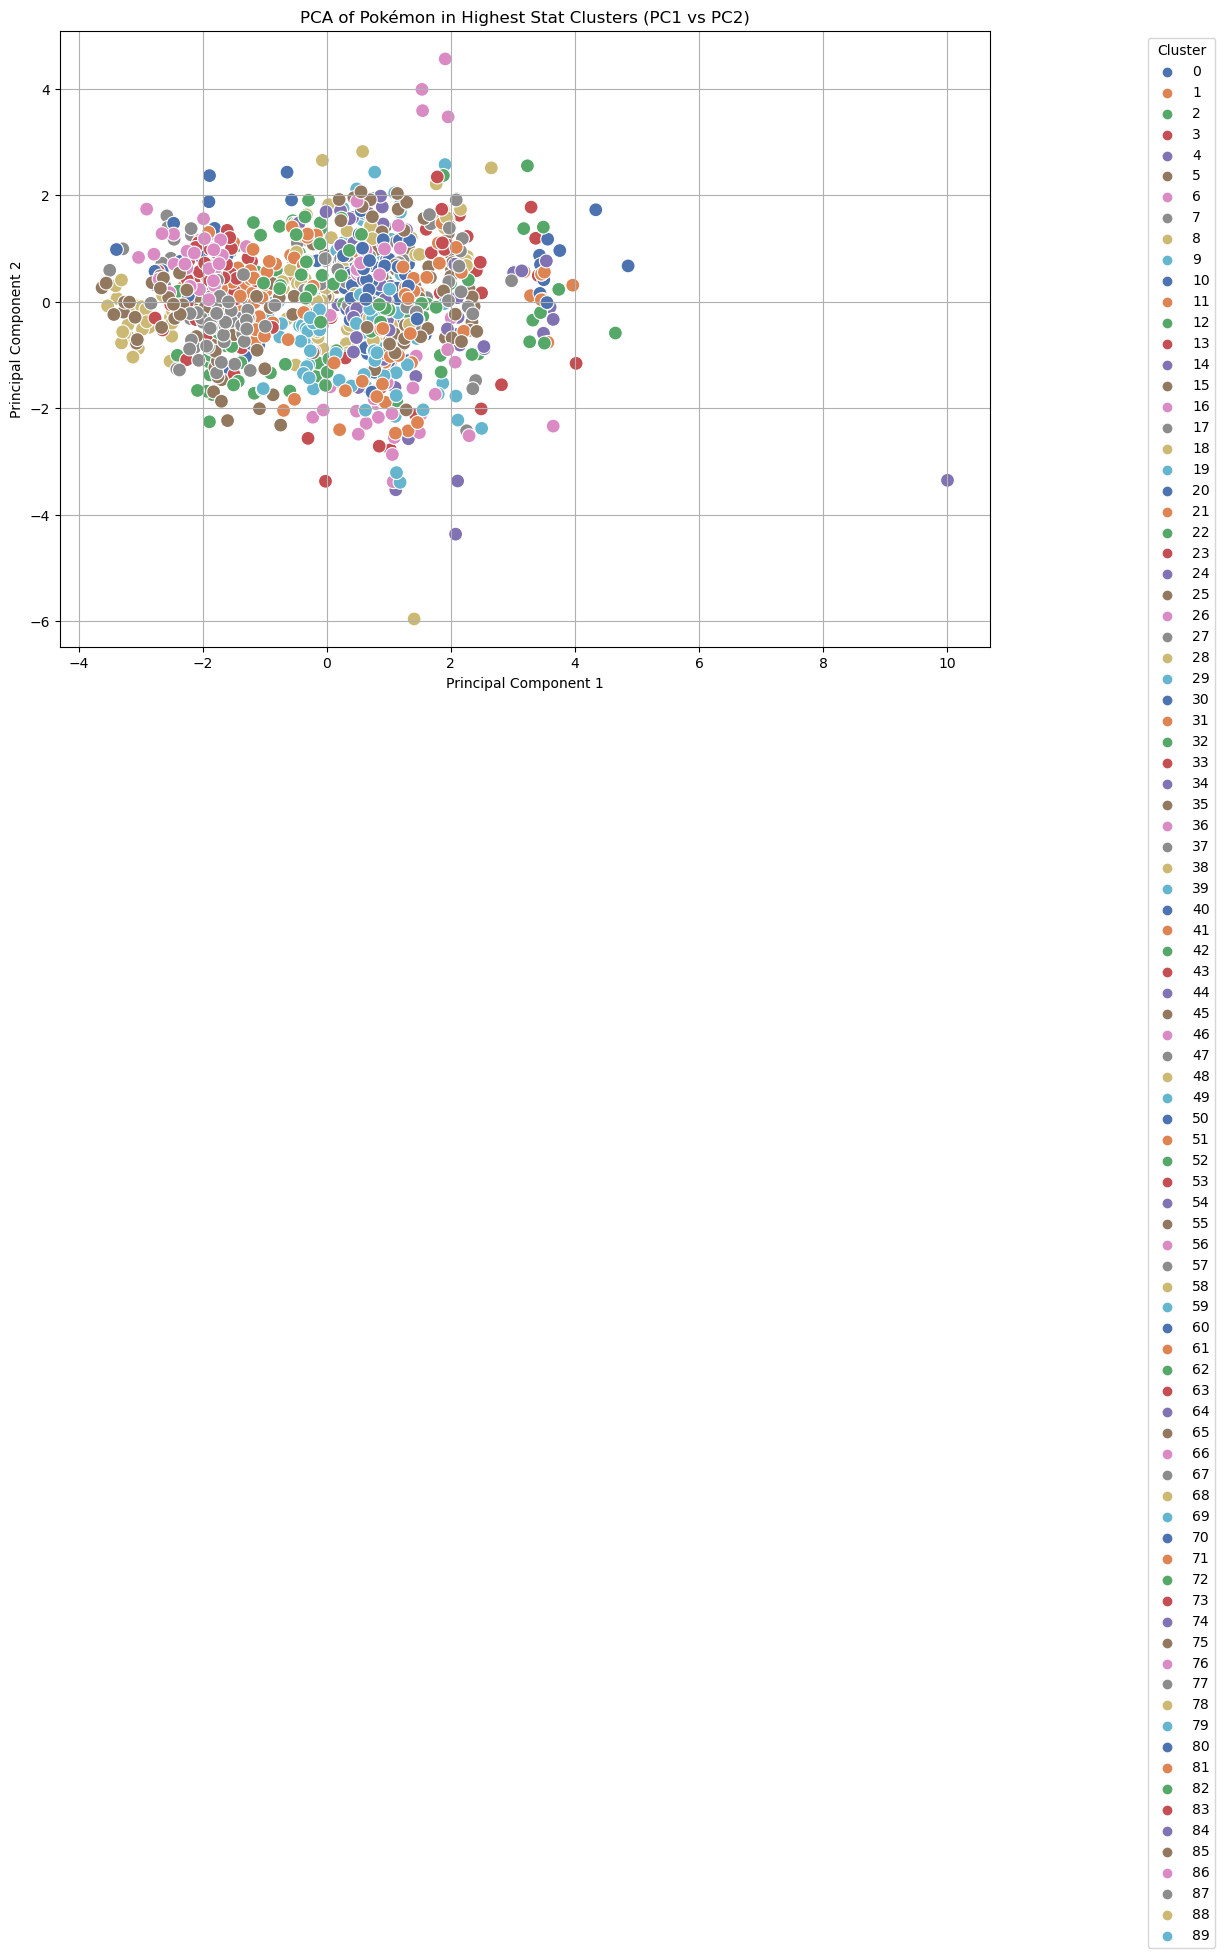

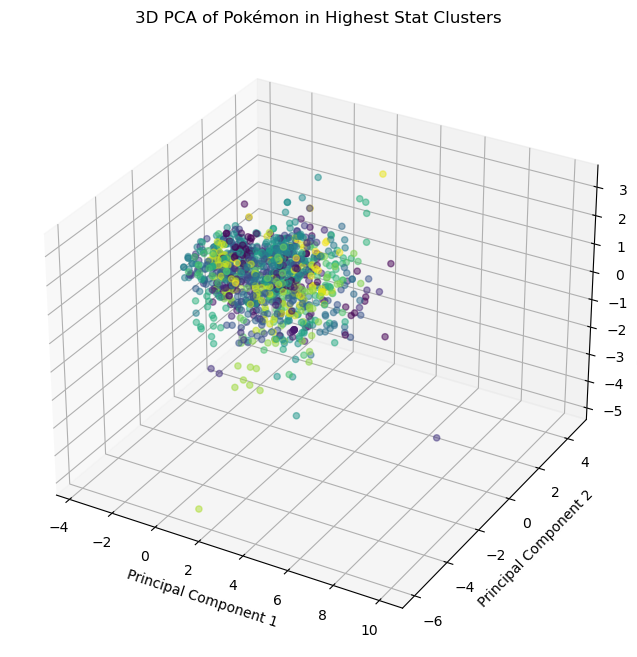

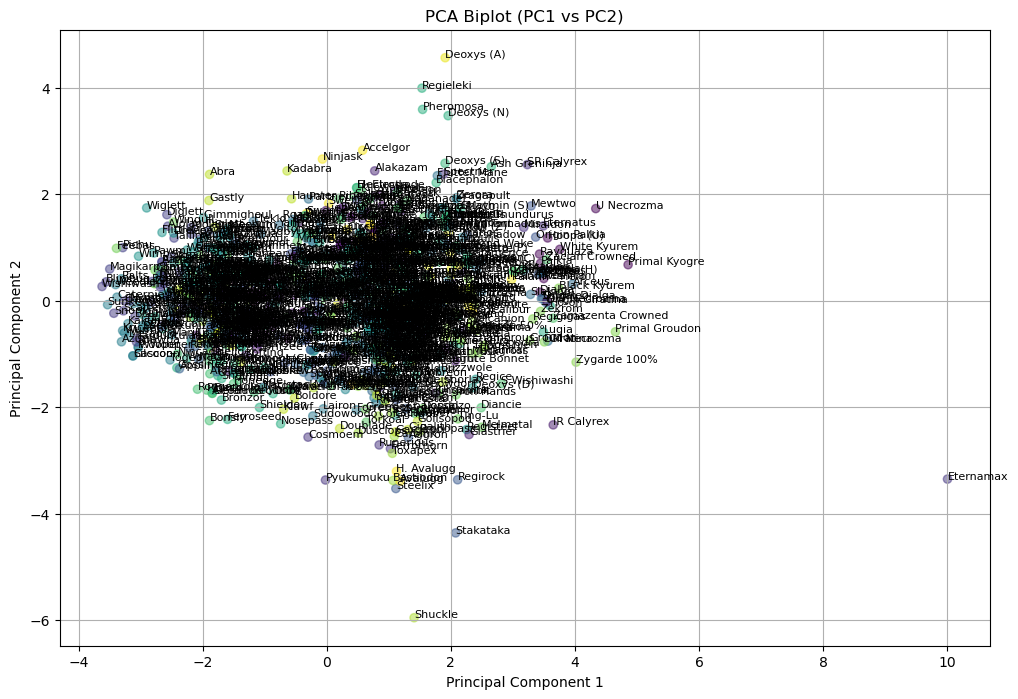

In [32]:
stats_columns=["HP","Atk","Def","SpA","SpD","Spe"]
scaler=StandardScaler()
scaled_stats=scaler.fit_transform(pokemon_df[stats_columns])

pca=PCA(n_components=3)
pca_result=pca.fit_transform(scaled_stats)

pokemon_pca_df=pd.DataFrame(data=pca_result, columns=["PC1","PC2","PC3"])
pokemon_pca_df["Cluster"]=pokemon_df["Cluster"]
pokemon_pca_df["Pokemon"]=pokemon_df["Pokemon"]

plt.figure(figsize=(10,6))
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker="o", linestyle="--")
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.show()

loadings=pd.DataFrame(pca.components_, columns=stats_columns, index=[f"PC{i+1}" for i in range(len(pca.components_))])
print("Component Loadings:\n", loadings)

plt.figure(figsize=(12,8))
sns.scatterplot(data=pokemon_pca_df, x="PC1", y="PC2", hue="Cluster", palette="deep", s=100)
plt.title("PCA of Pokémon in Highest Stat Clusters (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="upper right", bbox_to_anchor=(1.25,1))
plt.grid(True)
plt.show()

fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111, projection="3d")
ax.scatter(pokemon_pca_df["PC1"], pokemon_pca_df["PC2"], pokemon_pca_df["PC3"], 
           c=pokemon_pca_df["Cluster"], cmap="viridis", alpha=0.5)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.title("3D PCA of Pokémon in Highest Stat Clusters")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(pokemon_pca_df["PC1"], pokemon_pca_df["PC2"], c=pokemon_pca_df["Cluster"], cmap="viridis", alpha=0.5)
for i, txt in enumerate(pokemon_pca_df["Pokemon"]):
    plt.annotate(txt, (pokemon_pca_df["PC1"][i], pokemon_pca_df["PC2"][i]), fontsize=8)
plt.title("PCA Biplot (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()